<a href="https://colab.research.google.com/github/Adrianodelvincio/Machine_learning_project/blob/main/Project-ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit #sigmoide

In [2]:
sigmoid= lambda x,a : expit(a*x)
sigmoid_derivative=lambda x,a : a*expit(a*x) * (1 - expit(a*x))
lin = lambda x,a : a*x
lin_der=lambda x,a : a
relu= lambda x,a : a*np.maximum(0,x)
relu_der=lambda x,a : a*np.heaviside(x,1)
activation_function={"linear":lin,"sigmoid":sigmoid,"relu":relu}
derivative={"linear":lin_der,"sigmoid":sigmoid_derivative,"relu":relu_der}

net=lambda data_matrix,array_weight : data_matrix.dot(array_weight.T)
error= lambda label,out : np.sum((label-out)**2)

In [3]:
class Layer:
  def __init__(self,unit_number,input_matrix,func=("sigmoid",1),starting_points=0.1):
    self.input=np.array(input_matrix) 
    '''
    [[feat_1, ..., feat_n]_data_1,
    ......................
    ,[feat_1, ..., feat_n]_data_m]
    n=#feature
    m=#pattern
    '''
    self.unit_number=unit_number
    self.weight=np.random.uniform(-starting_points,starting_points,size=(unit_number,np.shape(self.input)[1]))
    '''
    [[wight_1,...,weight_j]_unit_1,
    ...............................
    ,[wight_1,...,weight_j]_unit_s]

    j=#pesi di una unità=#out layer precedente
    s=#unità del layer
    '''
    self.bias=np.random.uniform(-starting_points,starting_points,size=unit_number)
    self.function, self.slope=func
    self.func=lambda x : activation_function[self.function](x,self.slope)
    self.der_func=lambda x : derivative[self.function](x,self.slope)
    
  @property
  def net(self):
    #(self.inputs).dot((self.weight).T)
    #scorrendo le colonne trovi i net di tutti i neuroni, scorrendo le righe cambi pattern
    return net (self.input,self.weight)+self.bias

  @property
  def out(self):
    #scorrendo le colonne trovi i net di tutti i neuroni, scorrendo le righe cambi pattern
    return self.func(self.net)


In [4]:
class MLP:
  def __init__(self,structure,input,label,func,starting_point):
    self._structure=structure #numero di unità per ogni layer
    self.network=[]
    self.input=np.array(input)
    self.label=np.array(label)
    self.func=func #lista di tuple con (funzione, slope)
    self.starting_point=starting_point #lista degli start_point

    for layer,num_unit in enumerate(structure):
      if layer==0:
        self.network.append(Layer(num_unit,input,func=func[layer],starting_points=self.starting_point[layer]))
      else:
        self.network.append(Layer(num_unit,self.network[layer-1].out,func=func[layer],starting_points=self.starting_point[layer]))

  def __getattr__(self,attr):
      return [getattr(lay,attr) for lay in self.network]
    #estendi a metodi. getattr con metodo torna lista di metodi. si potrebbe risolvere aggiungendo un metodo call

  def feedforward(self):
    for lay_1,lay in zip(self.network[:-1:],self.network[1::]):
      lay.input=lay_1.out
  
  def learning_step(self,eta=0.1,lamb=1e-4,norm_L=2,alpha=0,nesterov=False):
    for reverse_layer_number,layer in enumerate(self.network[::-1]):
      if reverse_layer_number==0:
        delta=((self.label-layer.out)*layer.der_func(layer.net))     
      else:       
        delta=(np.matmul(delta,weight_1)*layer.der_func(layer.net))
      weight_1=layer.weight
      dW=np.sum([np.outer(i,j) for i,j in zip(delta,layer.input)],axis=0) #batch  
      db=np.sum(delta,axis=0)

      layer.weight+=eta*dW-norm_L*lamb*layer.weight**(norm_L-1)
      layer.bias+=eta*db-norm_L*lamb*layer.bias**(norm_L-1)

In [5]:
data=np.loadtxt("./drive/MyDrive/TR.csv",delimiter=",")
input=data[:,1:-2][0:1000]
label=data[:,-2:][0:1000]
test_in=data[:,1:-2][1000:-1]
test_label=data[:,-2:][1000:-1]


In [8]:
structure=[10,8,20,np.shape(label)[1]]
act_func=[("sigmoid",1),("sigmoid",1),("sigmoid",1),("linear",1)]
start=[0.001,0.05,0.05,0.01]
netw=MLP(structure,input,label,func=act_func,starting_point=start)
err=[]
test_err=[]

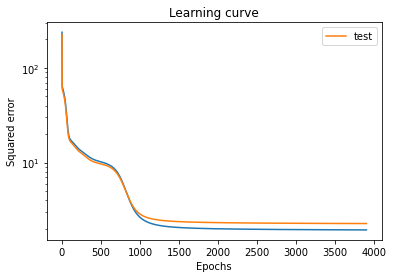

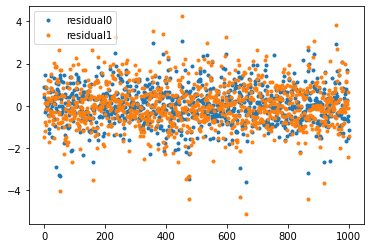

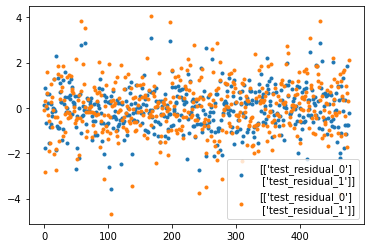

In [12]:
N=3000
learning_rate=5e-5
#err.append(error(np.array(label),np.heaviside(netw.network[-1].out.T-0.5,0)))
for epoch in range(N):
  netw.learning_step(eta=learning_rate,lamb=1e-4)
  netw.feedforward()
  err.append(error(np.array(label),netw.network[-1].out)/len(label))

  netw.network[0].input=test_in
  netw.feedforward()
  test_err.append(error(test_label,netw.network[-1].out)/len(test_label))
  netw.network[0].input=input
  netw.feedforward()
  #misl.append((error(np.array(label),np.heaviside(netw.network[-1].out-0.5,0)))/len(input))
x=np.linspace(1,len(err),len(err))
plt.plot(x,err)
plt.plot(x,test_err,label="test")

plt.title("Learning curve")
plt.xlabel("Epochs")
plt.ylabel("Squared error")
plt.yscale("log")
plt.legend()
plt.figure()
plt.plot(np.linspace(0,len(label),len(label)),label[:,0]-netw.network[-1].out[:,0],".",label="residual0")
plt.plot(np.linspace(0,len(label),len(label)),label[:,1]-netw.network[-1].out[:,1],".",label="residual1")
plt.legend()
plt.figure()

netw.network[0].input=test_in
netw.feedforward()

plt.plot(np.linspace(0,len(test_label),len(test_label)),test_label-netw.network[-1].out,".",label=np.array([["test_residual_0","test_residual_1"]]).T)
#plt.plot(np.linspace(0,len(test_label),len(test_label)),test_label[:,1]-netw.network[-1].out[:,1],".",label="test_residual1")
plt.legend()

netw.network[0].input=input
netw.feedforward()

#plt.plot(np.linspace(1,len(err),len(err)),misl)

In [290]:
input=np.array([[1,1,1],[0,0,1],[0,1,1],[1,1,0],[0,0,0],[0,1,0]])
label=np.array([[1,0,0,0,0,0]]).T
label=np.array([[1,1],[0,0],[0,0],[0,0],[0,0],[0,0]])
err=[]
structure=[2,np.shape(label)[1]]
act_func=[("sigmoid",1),("sigmoid",1)]
netw=MLP(structure,input,label,func=act_func,starting_point=start)

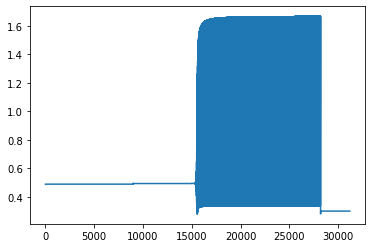

In [311]:

N=3000
learning_rate=1
#err.append(error(np.array(label),np.heaviside(netw.network[-1].out.T-0.5,0)))
for epoch in range(N):
  netw.learning_step(eta=learning_rate,lamb=1e-1)
  netw.feedforward()
  err.append(error(np.array(label),netw.network[-1].out)/len(label))
plt.plot(np.arange(len(err)),err)

In [312]:
netw.weight

[array([[-0.07670853,  0.01463132, -0.03118678],
        [-0.07670853,  0.01463132, -0.03118678]]),
 array([[-0.34055582, -0.34055582],
        [-0.34055582, -0.34055582]])]